## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [44]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [2]:
Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [45]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(US_Data,sheet='Food Expenditures 2017')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()


# Now prices
#p = read_sheets(Uganda_Data,sheet='Food Prices (2019-20)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
#p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
#p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2017")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)


This gives a dataframe of household characteristics $d$ with a simple structure.



In [32]:
x.shape

(90069,)

In [33]:
x.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [34]:
y.head()

i      t     m    j                                        
93704  2017  USA  Apple juice, 100%                            5.448890
                  Applesauce, flavored                         4.730921
                  Asparagus, fresh, cooked, no added fat       2.420368
                  Cereal (general mills cheerios honey nut)    3.323236
                  Cheese, mozzarella, part skim                3.344627
Name: grams, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [35]:
y

i      t     m    j                                              
93704  2017  USA  Apple juice, 100%                                  5.448890
                  Applesauce, flavored                               4.730921
                  Asparagus, fresh, cooked, no added fat             2.420368
                  Cereal (general mills cheerios honey nut)          3.323236
                  Cheese, mozzarella, part skim                      3.344627
                                                                       ...   
99152  2017  USA  Roll, white, soft                                  3.761200
                  Swiss steak                                        5.135798
                  Thuringer                                          5.620401
                  Vegetable beef soup, canned, prepared with milk    5.544200
                  Vegetable beef soup, home recipe                   5.515604
Name: grams, Length: 90069, dtype: float64

In [36]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [82]:

food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)

Shape of y_sample: (21995,)
Shape of d_sample: (1750, 3)


In [41]:
y_sample.unstack("j")

,,j,"Apple juice, 100%",Cereal (general mills cheerios honey nut),"Cheese, mozzarella, part skim",Fruit leather and fruit snacks candy,Ketchup,"Macaroni or noodles with cheese, made from packaged mix","Milk, low fat (1%)","Muffin, fruit","Pizza, cheese, from frozen, thin crust","Popcorn, microwave, butter flavored",...,"Sugar substitute, stevia, powder",Caesar dressing,"Chicken tenders or strips, breaded, from restaurant",Popsicle,"Pasta with tomato-based sauce, home recipe","Waffle, plain, from frozen","Fruit smoothie, with whole fruit and dairy","Crackers, sandwich, peanut butter filled","Iced coffee, brewed","Chicken nuggets, from fast food"
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,5.44889,3.323236,3.344627,3.258097,1.735189,4.744932,4.804021,4.867534,2.773838,1.252763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93711,2017,USA,NaN,NaN,NaN,NaN,3.688879,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93712,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93713,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93717,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99127,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99128,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99140,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
d_sample

,,k,age,sex,log_household
i,t,m,,,
93704,2017,USA,2.0,0,1.386294
93711,2017,USA,56.0,0,1.098612
93712,2017,USA,18.0,0,1.386294
93713,2017,USA,67.0,0,0.000000
93717,2017,USA,22.0,0,0.693147
...,...,...,...,...,...
99127,2017,USA,67.0,1,0.000000
99128,2017,USA,36.0,0,1.609438
99140,2017,USA,62.0,1,1.098612


In [40]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [22]:
y.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,3.931826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
?Regression

Init signature:
Regression(
    correct_miss=False,
    method='linear',
    K=None,
    bootstrap_tol=None,
    compute_se=False,
    rectify=False,
    verbose=False,
    min_obs=30,
    min_prop_items=0.1,
    alltm=True,
    **kwargs,
)
Docstring:     
A class which packages together data and methods for estimating a CFE demand system posed as a regression.

Data elements (and outputs) are typically pandas Series or DataFrames.  Indexes are kept consistent across objects, with:
   - i :: Indexes households
   - t :: Indexes periods
   - m :: Indexes markets
   - j :: Indexes goods
   - k :: Indexes household characteristics

Ethan Ligon                               October 2022
Init docstring:
To load data, use cfe.read_sql() or cfe.read_pickle().

To instantiate from data on log expenditures (y) and household
characteristics (d), supply each as pd.DataFrames, with indices for y
(i,t,m) and columns (j,) and for d indices (i,t,m) and columns (k,).
File:           /srv/conda/lib/pyt

In [43]:
from cfe import Regression

result = Regression(y=y_sample, d=d_sample, min_obs=10, min_prop_items= 0.002) 

In [50]:
from cfe import Regression

result = Regression(y=y_filtered, d=d, min_prop_items= 0.00001) 

And then one line to predict expenditures and estimate most of the things we need:



In [51]:
result.predicted_expenditures()

i      t     m    j                               
93704  2017  USA  Apple, raw                            41.710866
                  Banana, raw                           76.242971
                  Bread, white                          34.725692
                  Carrots, raw                           0.616009
                  Cheese, american                      14.220104
                                                         ...     
99152  2017  USA  Sugar, white, granulated or lump      18.784868
                  Tomatoes, for use on a sandwich       22.991018
                  Tomatoes, raw                        175.691750
                  Water, bottled, unsweetened         1698.586413
                  Water, tap                          1780.478757
Length: 113958, dtype: float64

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

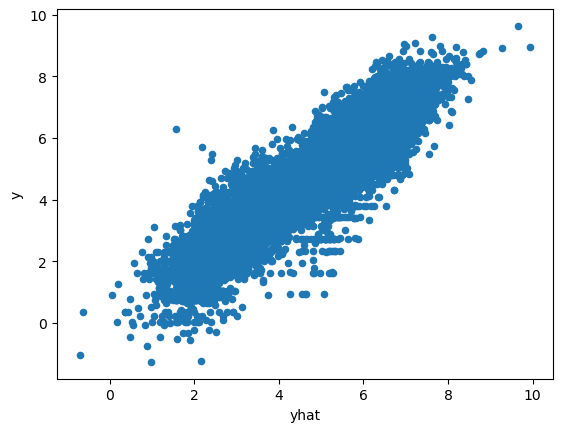

In [52]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



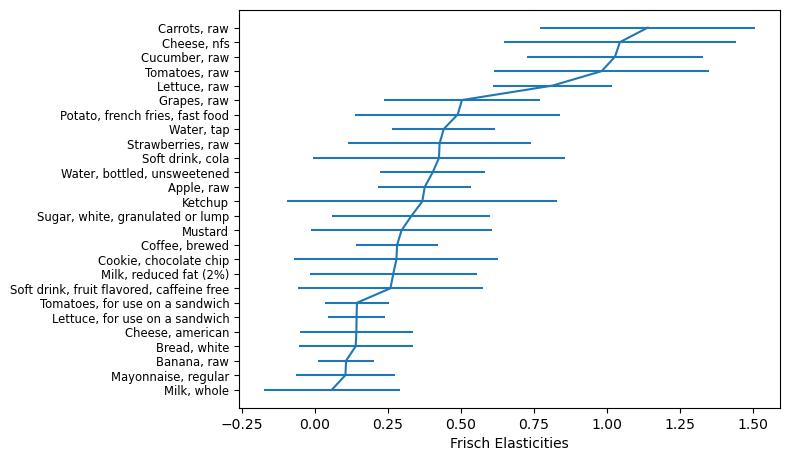

In [53]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [54]:
result.get_beta()

j
Apple, raw                                   0.375823
Banana, raw                                  0.106715
Bread, white                                 0.139589
Carrots, raw                                 1.138640
Cheese, american                             0.141835
Cheese, nfs                                  1.043444
Coffee, brewed                               0.281274
Cookie, chocolate chip                       0.278897
Cucumber, raw                                1.026858
Grapes, raw                                  0.503112
Ketchup                                      0.367410
Lettuce, for use on a sandwich               0.142565
Lettuce, raw                                 0.813291
Mayonnaise, regular                          0.104381
Milk, reduced fat (2%)                       0.268098
Milk, whole                                  0.058340
Mustard                                      0.296393
Potato, french fries, fast food              0.488427
Soft drink, cola          

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [55]:
result.get_gamma()

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.003059,-0.192426,0.016900,5.018679
"Banana, raw",0.002676,-0.120820,0.027885,4.722995
"Bread, white",-0.000725,-0.102885,-0.035676,3.938392
"Carrots, raw",-0.009904,-0.187517,-0.105184,3.237518
"Cheese, american",0.005139,-0.111494,0.063676,3.200868
"Cheese, nfs",-0.001172,-0.305766,-0.029136,2.817402
"Coffee, brewed",0.003209,-0.276431,-0.168539,5.870104
"Cookie, chocolate chip",0.004246,-0.241564,-0.082973,3.559912
"Cucumber, raw",-0.000008,-0.245715,-0.051110,3.822893


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

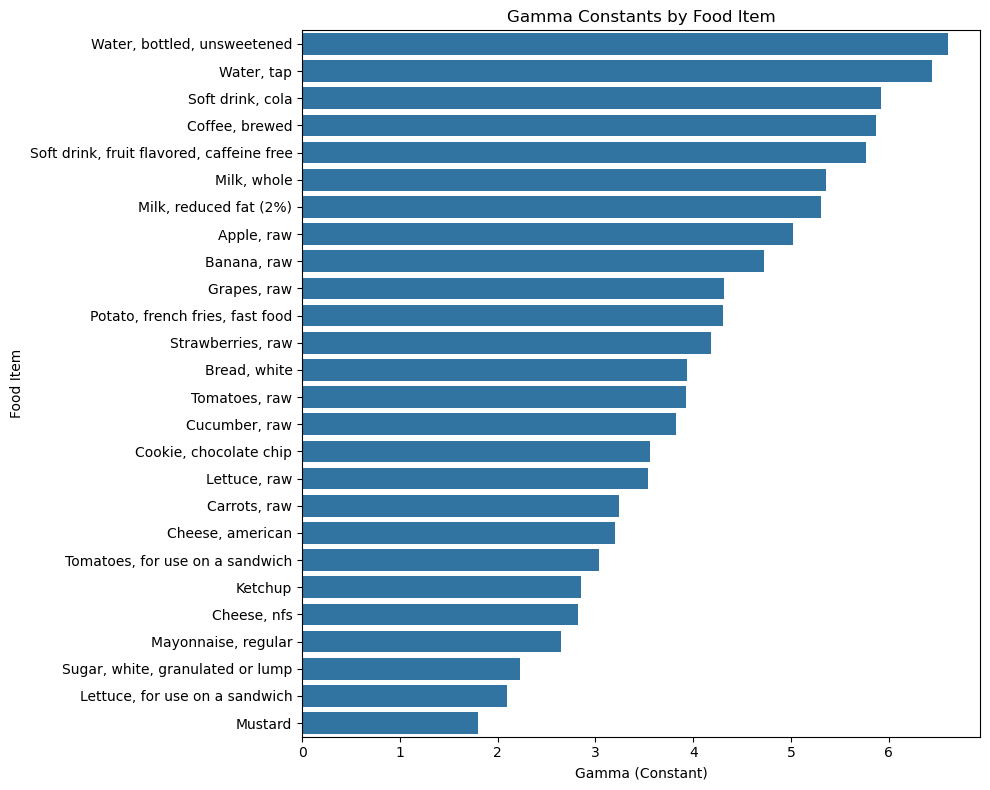

In [57]:
gamma = result.get_gamma()
gamma_sorted = gamma.sort_values(by="Constant", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=gamma_sorted, x="Constant", y="j")
plt.xlabel("Gamma (Constant)")
plt.ylabel("Food Item")
plt.title("Gamma Constants by Food Item")
plt.tight_layout()
plt.show()

In [58]:
gamma = result.get_gamma()
gamma[["Constant"]].sort_values("Constant")

k,Constant
j,
Mustard,1.797716
"Lettuce, for use on a sandwich",2.096294
"Sugar, white, granulated or lump",2.226951
"Mayonnaise, regular",2.647917
"Cheese, nfs",2.817402
Ketchup,2.854315
"Tomatoes, for use on a sandwich",3.031757
"Cheese, american",3.200868
"Carrots, raw",3.237518


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

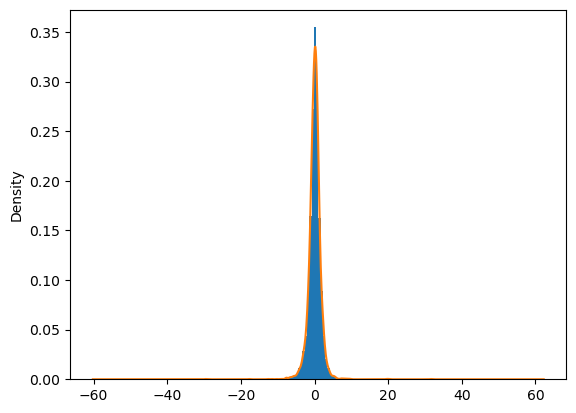

In [59]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [60]:
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)]

i      t     m  
93704  2017  USA   -3.700756
93705  2017  USA   -1.228227
93706  2017  USA    0.238115
93707  2017  USA   -0.548237
93708  2017  USA   -0.900486
                      ...   
99145  2017  USA    0.514496
99146  2017  USA   -6.621879
99149  2017  USA   -0.575562
99151  2017  USA   -0.228766
99152  2017  USA    0.996158
Length: 4341, dtype: float64

<Axes: ylabel='Density'>

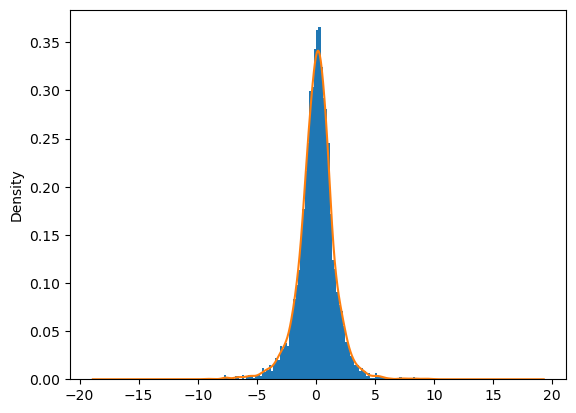

In [61]:
ax = result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.hist(bins=100,density=True)
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [49]:
result.to_pickle('us_estimates_2015.rgsn')

You can subsequently load this using



In [50]:
import cfe
result = cfe.regression.read_pickle('us_estimates_2015.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [99]:
p = pd.read_csv("proj3_min_cost_data - prices.csv")
p




p["u"] = "Kg"

p["m"] = "USA"

p["price"] = p["price"] * 10

p = p[p["t"] == "2017/2018"]



codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j") 
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})
p

# Now prices
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')
p
# Drop prices for goods we don't have expenditures for

# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T

#x_filtered.index.levels[-1].isin(p.columns)

In [100]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [104]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
#pbar = p.mean(axis=1)
#pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]
pbar = pbar.replace(np.nan, 1)

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

Index(['Apple, raw', 'Banana, raw', 'Bread, white', 'Carrots, raw',
       'Coffee, brewed', 'Cookie, chocolate chip', 'Cucumber, raw',
       'Grapes, raw', 'Ketchup', 'Lettuce, for use on a sandwich',
       'Lettuce, raw', 'Mayonnaise, regular', 'Milk, reduced fat (2%)',
       'Milk, whole', 'Mustard', 'Potato, french fries, fast food',
       'Soft drink, cola', 'Soft drink, fruit flavored, caffeine free',
       'Strawberries, raw', 'Sugar, white, granulated or lump',
       'Tomatoes, for use on a sandwich', 'Tomatoes, raw',
       'Water, bottled, unsweetened', 'Water, tap'],
      dtype='object', name='j')

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Grapes, raw'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

IndexError: index 24 is out of bounds for axis 0 with size 24

##### Engel Curves



Engel curves trace out how demand changes with budget:



In [1]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



In [1]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')